In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from sklearn import tree
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # Import random Forest Classifier
from sklearn.linear_model import LogisticRegression # Import random Forest Classifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.datasets import fetch_datasets
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced
from imblearn.combine import SMOTEENN, SMOTETomek
from statsmodels.stats.outliers_influence import variance_inflation_factor # for VIF multicollinearity
from joblib import Parallel, delayed

import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning) # to run prediction score with 
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

Loading helper classes

In [2]:
# %load ../project_helper/DataProbe.py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os, path
from statsmodels.stats.outliers_influence import variance_inflation_factor # for VIF multicollinearity
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder


class DataProbe:
    plot_dir = "../project_helper/data/plots"
    box_plot_dir = "../project_helper/data/plots/box"
    cat_plot_dir = "../project_helper/data/plots/cat"
    # RFC = RandomForestClassifier(n_estimators=100, warm_start=True, oob_score=True, max_features="sqrt")
    # LR = LogisticRegression(C=0.0001)

    @staticmethod
    def get_missing_data(df: pd.DataFrame):
        missing_values_total = df.isnull().sum()
        missing_values_perc = 100 * missing_values_total / len(df)

        missing_data = pd.concat([missing_values_total, missing_values_perc], axis=1)
        missing_data.sort_values([1], ascending=False, inplace=True)
        return missing_data

    @staticmethod
    def save_plot_for_columns(df: pd.DataFrame):
        sns.set(style="darkgrid")
        #my_path = os.path.abspath(DataProbe.plot_dir)
        # os.chdir(my_path)
        for col in df.columns:
            col_values = df[col].value_counts()
            sns.barplot(col_values.index, col_values.values, alpha=0.9)
            plt.figure()
            plt.title('Frequency Distribution of {}'.format(col))
            plt.ylabel('Number of Occurrences', fontsize=12)
            plt.xlabel("Field {}".format(col), fontsize=12)
            # plt.savefig('plot_{}.png'.format(col))
            plt.show()

    @staticmethod
    def cat_plot_for_columns(df: pd.DataFrame):
        sns.set(style="darkgrid")
        my_path = os.path.abspath(DataProbe.cat_plot_dir)
        os.chdir(my_path)
        for col in df.columns:
            sns.boxplot(data=df[col])
            plt.figure()
            plt.title('Frequency Distribution of {}'.format(col))
            # plt.savefig('plot_{}.png'.format(col))
            plt.show()

    @staticmethod
    def check_for_outliers(df: pd.DataFrame):
        os.mkdir(DataProbe.box_plot_dir)
        os.chdir(DataProbe.box_plot_dir)
        new_df = df.select_dtypes([np.number])
        for col in new_df.columns:
            plt.boxplot(df[col])
            plt.savefig('boxplot_{}.png'.format(col))
            plt.show()

    @staticmethod
    def remove_outliers(df: pd.DataFrame, sdFromPercentile: float):
        print("Size of the dataset before trimming outliers" + df.shape)
        q1, q3 = np.percentile(df, [25, 75])
        iqr = q3 - q1
        lb = q1 - (sdFromPercentile * iqr)
        ub = q3 + (sdFromPercentile * iqr)
        print(IQR)
        
        IQR_outliers = ((df['amount'] < (Q1 - 1.5 * IQR)) |(df['amount'] > (Q3 + 1.5 * IQR)))
        print(IQR_outliers)
        print("Size of the dataset before trimming outliers" + df.shape)

    @staticmethod
    def find_unique_values_columns(df: pd.DataFrame):
        for col in df.columns:
            print("unique value for {} is {}".format(col, list(df[col].unique())))

    @staticmethod
    def calculate_VIF(df: pd.DataFrame):
        threshold = 5.0
        columns = df.columns
        vif = pd.DataFrame()
        vif["VIF factor"] = [Parallel(n_jobs=-1, verbose=5)(
            delayed(variance_inflation_factor)(df[columns].values, df.columns.get_loc(i)) for i in df.columns)]
        vif["features"] = X.columns
        print(vif.round(1))

    @staticmethod
    def plot_target(df: pd.DataFrame):
        colors = ["#0101DF", "#DF0101"]
        sns.countplot('TARGET', data=df, palette=colors)
        plt.title('Class Distributions \n (0: No Default || 1: Default)', fontsize=14)

    # copied from https://www.kaggle.com/npramod/techniques-to-deal-with-imbalanced-data
    @staticmethod
    def transform(transformer, X, y):
        print("Transforming {}".format(transformer.__class__.__name__))
        X_resampled, y_resampled = transformer.fit_sample(X.values, y.values.ravel())
        return transformer.__class__.__name__, pd.DataFrame(X_resampled), pd.DataFrame(y_resampled)

    # for label encoding
    @staticmethod
    def label_encode(training_data : pd.DataFrame, testing_data : pd.DataFrame):

        encoder = LabelEncoder()
        le_count = 0

        # Iterate through the columns
        for col in training_data:
            if training_data[col].dtype == 'object':
                # If 2 or fewer unique categories
                if len(list(training_data[col].unique())) <= 2:
                    # Train on the training data
                    encoder.fit(training_data[col])
                    # Transform both training and testing data
                    training_data[col] = encoder.transform(training_data[col])
                    testing_data[col] = encoder.transform(testing_data[col])

                    # Keep track of how many columns were label encoded
                    le_count += 1

        print('%d columns were label encoded.' % le_count)
        return training_data, testing_data

    


In [3]:
def listdir(path):
    if os.path.exists(path):
        return os.listdir(path)
    else:
        return []
    
def get_files_with_path(path):
    file_list = listdir(path)
    file_ref = dict()
    for f in file_list:
        file_ref[f] = path + '/' + f
    return file_ref

In [4]:
# regression helper functions
RFC = RandomForestClassifier(n_estimators=100, warm_start=True, oob_score=True, max_features="sqrt", random_state=0)
RFC_AFTER_FEATURE_REDUCTION = RandomForestClassifier(n_estimators=100, warm_start=True, oob_score=True, max_features="sqrt", random_state=0)
LR = LogisticRegression(C=0.0001)
CLF = DecisionTreeClassifier()
scores = []

def run_DT(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame):
    # Train Decision Tree Classifer
    clf = CLF.fit(x_train, y_train)

    # Predict the response for test datase
    y_pred = clf.predict(x_test)
    return clf, y_pred

def run_RFC(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame):
    # Train Random Forest Classifer
    rfc = RFC.fit(x_train, y_train)

    # Predict the response for test dataset
    y_pred = rfc.predict(x_test)
    return rfc, y_pred

def run_RFC_with_important_features(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame):
    # Train Random Forest Classifer
    rfc = RFC_AFTER_FEATURE_REDUCTION.fit(x_train, y_train)

    # Predict the response for test dataset
    y_pred = rfc.predict(x_test)
    return rfc, y_pred

def run_LR(x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame):
    lr = LR.fit(x_train, y_train)
    y_logistic_pred = lr.predict(x_test)
    return lr, y_logistic_pred

def add_to_scores(regression_type: str, x_train: pd.DataFrame, y_train: pd.Series, x_test: pd.DataFrame,
                      y_test: pd.Series, y_pred: pd.Series):
    scores.append((regression_type,
                        metrics.f1_score(y_test, y_pred, average='macro'),
                        metrics.precision_score(y_test, y_pred, average='macro'),
                        metrics.recall_score(y_test, y_pred, average='macro'),
                        metrics.accuracy_score(y_test, y_pred),
                        metrics.confusion_matrix(y_test, y_pred)))

def print_scores():
    sampling_results = pd.DataFrame(scores, columns=['Sampling/Regression Type', 'f1', 'precision', 'recall', 'accuracy',
                                                         'confusion_matrix'])
    return sampling_results

Phase 1 : checking and correcting data

In [5]:
input_path = "../data/input"
fileList = listdir(input_path)
print(fileList)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [6]:
file_ref = get_files_with_path(input_path)
print(file_ref)

{'application_test.csv': '../data/input/application_test.csv', 'application_train.csv': '../data/input/application_train.csv', 'bureau.csv': '../data/input/bureau.csv', 'bureau_balance.csv': '../data/input/bureau_balance.csv', 'credit_card_balance.csv': '../data/input/credit_card_balance.csv', 'HomeCredit_columns_description.csv': '../data/input/HomeCredit_columns_description.csv', 'installments_payments.csv': '../data/input/installments_payments.csv', 'POS_CASH_balance.csv': '../data/input/POS_CASH_balance.csv', 'previous_application.csv': '../data/input/previous_application.csv', 'sample_submission.csv': '../data/input/sample_submission.csv'}


In [7]:
training_data = pd.read_csv(file_ref.get("application_train.csv"))
testing_data = pd.read_csv(file_ref.get("application_test.csv"))

verbose=True, null_counts=True to print all columns information, specifically interested in datatype

In [8]:
print(training_data.info(verbose=True, null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      307511 non-null int64
TARGET                          307511 non-null int64
NAME_CONTRACT_TYPE              307511 non-null object
CODE_GENDER                     307511 non-null object
FLAG_OWN_CAR                    307511 non-null object
FLAG_OWN_REALTY                 307511 non-null object
CNT_CHILDREN                    307511 non-null int64
AMT_INCOME_TOTAL                307511 non-null float64
AMT_CREDIT                      307511 non-null float64
AMT_ANNUITY                     307499 non-null float64
AMT_GOODS_PRICE                 307233 non-null float64
NAME_TYPE_SUITE                 306219 non-null object
NAME_INCOME_TYPE                307511 non-null object
NAME_EDUCATION_TYPE             307511 non-null object
NAME_FAMILY_STATUS              307511 non-null object
NAME_HOUSING_TYPE               307511 non-null object
REGION_

In [9]:
training_data.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [10]:
print("training data before drop na : {}".format(training_data.shape))

training data before drop na : (307511, 122)


## Phase 2 : Dropping missing data columns

drop columns with more than 80% missing data

In [11]:
training_data.dropna(thresh=len(training_data)*.2, axis=1, inplace=True)
print("training data after drop na : {}".format(training_data.shape))

training data after drop na : (307511, 122)


So practically, no effect

Let's try to find out the missing data

In [12]:
missing_data = DataProbe.get_missing_data(training_data)
print(missing_data)

                                  0          1
COMMONAREA_MEDI              214865  69.872297
COMMONAREA_AVG               214865  69.872297
COMMONAREA_MODE              214865  69.872297
NONLIVINGAPARTMENTS_MODE     213514  69.432963
NONLIVINGAPARTMENTS_AVG      213514  69.432963
NONLIVINGAPARTMENTS_MEDI     213514  69.432963
FONDKAPREMONT_MODE           210295  68.386172
LIVINGAPARTMENTS_MODE        210199  68.354953
LIVINGAPARTMENTS_AVG         210199  68.354953
LIVINGAPARTMENTS_MEDI        210199  68.354953
FLOORSMIN_AVG                208642  67.848630
FLOORSMIN_MODE               208642  67.848630
FLOORSMIN_MEDI               208642  67.848630
YEARS_BUILD_MEDI             204488  66.497784
YEARS_BUILD_MODE             204488  66.497784
YEARS_BUILD_AVG              204488  66.497784
OWN_CAR_AGE                  202929  65.990810
LANDAREA_MEDI                182590  59.376738
LANDAREA_MODE                182590  59.376738
LANDAREA_AVG                 182590  59.376738
BASEMENTAREA_

In [13]:
training_data_categorical = training_data.select_dtypes(include=['object']).copy()
training_data_categorical.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN,NaN,NaN,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN,NaN,NaN,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN,NaN,NaN,NaN


In [14]:
training_data_categorical.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 16 columns):
NAME_CONTRACT_TYPE            307511 non-null object
CODE_GENDER                   307511 non-null object
FLAG_OWN_CAR                  307511 non-null object
FLAG_OWN_REALTY               307511 non-null object
NAME_TYPE_SUITE               306219 non-null object
NAME_INCOME_TYPE              307511 non-null object
NAME_EDUCATION_TYPE           307511 non-null object
NAME_FAMILY_STATUS            307511 non-null object
NAME_HOUSING_TYPE             307511 non-null object
OCCUPATION_TYPE               211120 non-null object
WEEKDAY_APPR_PROCESS_START    307511 non-null object
ORGANIZATION_TYPE             307511 non-null object
FONDKAPREMONT_MODE            97216 non-null object
HOUSETYPE_MODE                153214 non-null object
WALLSMATERIAL_MODE            151170 non-null object
EMERGENCYSTATE_MODE           161756 non-null object
dtypes: object(16)
memory usage: 37.5+ MB


In [15]:
DataProbe.find_unique_values_columns(training_data_categorical)

unique value for NAME_CONTRACT_TYPE is ['Cash loans', 'Revolving loans']
unique value for CODE_GENDER is ['M', 'F', 'XNA']
unique value for FLAG_OWN_CAR is ['N', 'Y']
unique value for FLAG_OWN_REALTY is ['Y', 'N']
unique value for NAME_TYPE_SUITE is ['Unaccompanied', 'Family', 'Spouse, partner', 'Children', 'Other_A', nan, 'Other_B', 'Group of people']
unique value for NAME_INCOME_TYPE is ['Working', 'State servant', 'Commercial associate', 'Pensioner', 'Unemployed', 'Student', 'Businessman', 'Maternity leave']
unique value for NAME_EDUCATION_TYPE is ['Secondary / secondary special', 'Higher education', 'Incomplete higher', 'Lower secondary', 'Academic degree']
unique value for NAME_FAMILY_STATUS is ['Single / not married', 'Married', 'Civil marriage', 'Widow', 'Separated', 'Unknown']
unique value for NAME_HOUSING_TYPE is ['House / apartment', 'Rented apartment', 'With parents', 'Municipal apartment', 'Office apartment', 'Co-op apartment']
unique value for OCCUPATION_TYPE is ['Laborers

## Phase 3 : Categorical data encoding

In [16]:
# let's first encode categorical data
# first we will encode data taht has binary values( using values_count size <=2)
training_data, testing_data = DataProbe.label_encode(training_data, testing_data)
print(training_data.info(verbose=True, null_counts=True))
print(testing_data.info(verbose=True, null_counts=True))

3 columns were label encoded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
SK_ID_CURR                      307511 non-null int64
TARGET                          307511 non-null int64
NAME_CONTRACT_TYPE              307511 non-null int32
CODE_GENDER                     307511 non-null object
FLAG_OWN_CAR                    307511 non-null int32
FLAG_OWN_REALTY                 307511 non-null int32
CNT_CHILDREN                    307511 non-null int64
AMT_INCOME_TOTAL                307511 non-null float64
AMT_CREDIT                      307511 non-null float64
AMT_ANNUITY                     307499 non-null float64
AMT_GOODS_PRICE                 307233 non-null float64
NAME_TYPE_SUITE                 306219 non-null object
NAME_INCOME_TYPE                307511 non-null object
NAME_EDUCATION_TYPE             307511 non-null object
NAME_FAMILY_STATUS              307511 non-null object
NAME_HOUSING_TYPE               307

In [17]:
# one-hot encoding of categorical variables
training_data = pd.get_dummies(training_data)
testing_data = pd.get_dummies(testing_data)

In [18]:
training_data.replace([np.inf, -np.inf], np.nan)
training_data.fillna(method='ffill', inplace=True)
testing_data.replace([np.inf, -np.inf], np.nan)
testing_data.fillna(method='ffill', inplace=True)

# As this data was part of a kaggle competition, training data doesn't have target variable

<i>The testing data doesn't have TARGET (y) column!
As this data set is part of the kaggle competition that has already expired,
the way to validate your dataset for target values is using as a separate submission function available on kaggle</i>

In [19]:
print('target' in training_data.columns.str.lower())

True


In [20]:
print('target' in testing_data.columns.str.lower())

False


# The decision tree approach ( refered from https://www.datacamp.com/community/tutorials/decision-tree-classification-python ) to help me identify feature importance

In [21]:
training_data.replace([np.inf, -np.inf], np.nan)
training_data.fillna(method='ffill', inplace=True)
training_data.dropna(inplace=True)
data_decision_tree = training_data.copy()
# data_decision_tree = training_data.copy()
data_decision_tree_Y = data_decision_tree['TARGET']
feature_cols = list(data_decision_tree.columns.difference(['TARGET']))

X = data_decision_tree[feature_cols]
Y = data_decision_tree_Y

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)  # 80% training and 20% test

# regressionHelper = RegressionHelper()
clf, y_pred = run_DT(X_train, y_train, X_test)
add_to_scores("Decision Tree Classifier", X_train, y_train, X_test, y_test, y_pred)

## Running with random forest classifier

In [22]:
# running random forest
rfc, y_pred = run_RFC(X_train, y_train, X_test)
add_to_scores("Random Forest Classifier_without_sampling", X_train, y_train, X_test, y_test, y_pred)

# Feature reduction

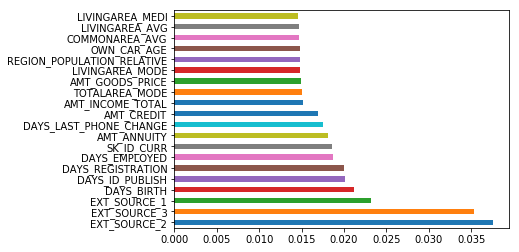

In [23]:
# lets try to reduce the number of features
feature_importances = pd.DataFrame(rfc.feature_importances_,index = X_train.columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = pd.Series(rfc.feature_importances_,index=X_train.columns)
feature_importances.nlargest(20).plot(kind='barh')
plt.show()

## Running with logistic regression

In [24]:
# Running logistic regression
lr, y_logistic_pred = run_LR(X_train, y_train, X_test)
add_to_scores("Logistic Regression", X_train, y_train, X_test, y_test, y_pred)

C:\Users\arpit\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Feature importance
<i> As a part of random forest classifier inbuilt feature importances, I will select the n=20 largest 'importances' features

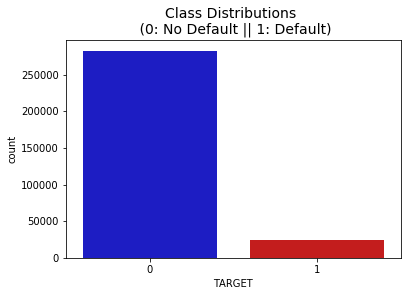

In [25]:
DataProbe.plot_target(training_data)

In [26]:
print(training_data['TARGET'].value_counts())

0    282685
1     24824
Name: TARGET, dtype: int64


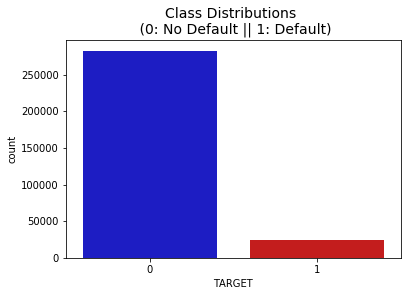

In [27]:
list_of_important_columns = feature_importances.nlargest(20).index.values
list_of_important_columns = np.append(list_of_important_columns, 'TARGET')
# print(list_of_important_columns)
training_data_important = training_data[list_of_important_columns]
DataProbe.plot_target(training_data_important)

In [28]:
print(training_data_important['TARGET'].value_counts())

0    282685
1     24824
Name: TARGET, dtype: int64


## Using the important features to run random forest

In [29]:
model_data_train = training_data_important.copy()
model_data_train_Y = model_data_train['TARGET']
feature_cols = list(model_data_train.columns.difference(['TARGET']))
X = model_data_train[feature_cols]
Y = model_data_train_Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
rfc, y_pred = run_RFC_with_important_features(X_train, y_train, X_test)
add_to_scores("Random Forest Classifier reduced features", X_train, y_train, X_test, y_test, y_pred)

# Sampling
<i> Though the result are pretty good after the last regression run, I am going to try some sampling 
* SMOTE
* RandomOverSampler
* NearMiss
* RandomUnderSampler
* SMOTEENN
* SMOTETomek
    
# Based on https://www.kaggle.com/npramod/techniques-to-deal-with-imbalanced-data

In [30]:
# Running some sampling

datasets = []
datasets.append(("base",X_train,y_train))
datasets.append(DataProbe.transform(SMOTE(n_jobs=-1),X_train,y_train))
datasets.append(DataProbe.transform(RandomOverSampler(),X_train,y_train))
datasets.append(DataProbe.transform(NearMiss(n_jobs=-1),X_train,y_train))
datasets.append(DataProbe.transform(RandomUnderSampler(),X_train,y_train))
datasets.append(DataProbe.transform(SMOTEENN(),X_train,y_train))
datasets.append(DataProbe.transform(SMOTETomek(),X_train,y_train))

Transforming SMOTE
Transforming RandomOverSampler
Transforming NearMiss
Transforming RandomUnderSampler
Transforming SMOTEENN
Transforming SMOTETomek


In [38]:
model_data_train = training_data_important.copy()
model_data_train_Y = model_data_train['TARGET']
feature_cols = list(model_data_train.columns.difference(['TARGET']))
XX = model_data_train[feature_cols]
YY = model_data_train_Y
for transformer_type, X, Y in datasets:
    X_train, X_test, y_train, y_test = train_test_split(XX, YY, test_size=0.2, random_state=0)
    rfc, rfc_pred = run_RFC_with_important_features(X_train, y_train, X_test)
    scores.append((transformer_type,
                    metrics.f1_score(y_test,rfc_pred, average='macro'),
                           metrics.precision_score(y_test,rfc_pred, average='macro'),
                           metrics.recall_score(y_test,rfc_pred, average='macro'),
                           metrics.accuracy_score(y_test,rfc_pred),
                           metrics.confusion_matrix(y_test,rfc_pred)))
    

In [ ]:
correlations = X_train.corr()

lets try to plot this using heatmap

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlations,xticklabels=correlations.columns,
                 yticklabels=correlations.columns, cbar=True, vmin=-0.5, vmax=0.5,
                 fmt='.2f', annot_kws={'size': 10}, annot=True, 
                 square=True, cmap=plt.cm.Blues)
ticks = np.arange(correlations.shape[0]) + 0.5
# ax.set_xticks(ticks)
# ax.set_xticklabels(correlations.columns, rotation=90, fontsize=20)
# ax.set_yticks(ticks)
# ax.set_yticklabels(correlations.columns, rotation=360, fontsize=20)

ax.set_title('correlation matrix')
plt.tight_layout()
plt.savefig("corr_matrix_incl_anno_double.png", dpi=300)

In [43]:
training_data_copy = training_data_important.copy()
print("Size of the dataset before trimming outliers", training_data_copy.shape)
for col in training_data_copy:
    q1, q3 = np.percentile(training_data_copy[col], [5, 95])
    iqr = q3 - q1
    lb = q1 - (1.5 * iqr)
    ub = q3 + (1.5 * iqr)
    # print("Column {} iqr {}".format(col, iqr))
    # QR_outliers = ((training_data[col] < lb) |(training_data[col] > ub))
    outlier = [lb, ub]
    # print("Column {} iqr {}".format(col, outlier))
    training_data_copy = training_data_copy[~(((training_data[col] < lb)|(training_data[col] > ub)))]
    print("After deleting col {} , target value count {} ".format(col,training_data_copy['TARGET'].value_counts()))

Size of the dataset before trimming outliers (307509, 21)
After deleting col EXT_SOURCE_2 , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col EXT_SOURCE_3 , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col EXT_SOURCE_1 , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col DAYS_BIRTH , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col DAYS_ID_PUBLISH , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col DAYS_REGISTRATION , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col DAYS_EMPLOYED , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col SK_ID_CURR , target value count 0    282685
1     24824
Name: TARGET, dtype: int64 
After deleting col AMT_ANNUITY , target value count 0    282488
1     24821
Name: TARGET, dtype: 

After deleting all outliers,  
target value count 
0    278547
1     24542
Name: TARGET, dtype: int64 

In [45]:
training_data_copy.replace([np.inf, -np.inf], np.nan)
training_data_copy.fillna(method='ffill', inplace=True)
training_data_copy.dropna(inplace=True)
data_decision_tree = training_data_copy.copy()
data_decision_tree_Y = data_decision_tree['TARGET']
feature_cols = list(data_decision_tree.columns.difference(['TARGET']))

X = data_decision_tree[feature_cols]
Y = data_decision_tree_Y

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)  # 80% training and 20% test
rfc, y_pred = run_RFC_with_important_features(X_train, y_train, X_test)
add_to_scores("Random Forest Classifier_outlier_removed", X_train, y_train, X_test, y_test, y_pred)

In [46]:
sampling_results = pd.DataFrame(scores,columns=['Sampling Type','f1','precision','recall','accuracy','confusion_matrix'])
sampling_results.head

<bound method NDFrame.head of                                 Sampling Type        f1  precision    recall  \
0                    Decision Tree Classifier  0.529344   0.527864  0.531524   
1   Random Forest Classifier_without_sampling  0.478677   0.459099  0.500000   
2                         Logistic Regression  0.478677   0.459099  0.500000   
3   Random Forest Classifier reduced features  0.482100   0.668381  0.501561   
4                                        base  0.936785   0.990640  0.895190   
5                                       SMOTE  0.936785   0.990640  0.895190   
6                           RandomOverSampler  0.936785   0.990640  0.895190   
7                                    NearMiss  0.936785   0.990640  0.895190   
8                          RandomUnderSampler  0.936785   0.990640  0.895190   
9                                    SMOTEENN  0.936785   0.990640  0.895190   
10                                 SMOTETomek  0.936785   0.990640  0.895190   
11   Rando

In [47]:
sampling_results

,Sampling Type,f1,precision,recall,accuracy,confusion_matrix
0,Decision Tree Classifier,0.529344,0.527864,0.531524,0.849241,"[[51467, 5004], [4268, 763]]"
1,Random Forest Classifier_without_sampling,0.478677,0.459099,0.500000,0.918198,"[[56471, 0], [5031, 0]]"
2,Logistic Regression,0.478677,0.459099,0.500000,0.918198,"[[56471, 0], [5031, 0]]"
3,Random Forest Classifier reduced features,0.482100,0.668381,0.501561,0.917808,"[[56429, 25], [5030, 18]]"
4,base,0.936785,0.990640,0.895190,0.983139,"[[56565, 3], [1034, 3900]]"
5,SMOTE,0.936785,0.990640,0.895190,0.983139,"[[56565, 3], [1034, 3900]]"
6,RandomOverSampler,0.936785,0.990640,0.895190,0.983139,"[[56565, 3], [1034, 3900]]"
7,NearMiss,0.936785,0.990640,0.895190,0.983139,"[[56565, 3], [1034, 3900]]"
8,RandomUnderSampler,0.936785,0.990640,0.895190,0.983139,"[[56565, 3], [1034, 3900]]"
9,SMOTEENN,0.936785,0.990640,0.895190,0.983139,"[[56565, 3], [1034, 3900]]"
